<a href="https://colab.research.google.com/github/AnnieCRY/DS5220_project/blob/master/SequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [0]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [4]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "./", # give path here
    # Model hyper parameters
    char_embedding_size=4,
    rnn_hidden_size= 16, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	./vectorizer.json
	./model.pth
Using CUDA: True


### Initializations

In [0]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model16 = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=16,
                               padding_idx=vectorizer.char_vocab.mask_index)
model4 = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=4,
                               padding_idx=vectorizer.char_vocab.mask_index)
model8 = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=8,
                               padding_idx=vectorizer.char_vocab.mask_index)
model2 = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=2,
                               padding_idx=vectorizer.char_vocab.mask_index)


### Training loop

In [0]:
 def training(model): 
  mask_index = vectorizer.char_vocab.mask_index

  model = model.to(args.device)


  optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                            mode='min', factor=0.5,
                                            patience=1)
  train_state = make_train_state(args)

  epoch_bar = tqdm_notebook(desc='training routine', 
                            total=args.num_epochs,
                            position=0)

  dataset.set_split('train')
  train_bar = tqdm_notebook(desc='split=train',
                            total=dataset.get_num_batches(args.batch_size), 
                            position=1, 
                            leave=True)
  dataset.set_split('val')
  val_bar = tqdm_notebook(desc='split=val',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)

  try:
      for epoch_index in range(args.num_epochs):
          train_state['epoch_index'] = epoch_index

          # Iterate over training dataset

          # setup: batch generator, set loss and acc to 0, set train mode on
          dataset.set_split('train')
          batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
          running_loss = 0.0
          running_acc = 0.0
          model.train()
          
          for batch_index, batch_dict in enumerate(batch_generator):
              # the training routine is these 5 steps:

              # --------------------------------------    
              # step 1. zero the gradients
              optimizer.zero_grad()

              # step 2. compute the output
              y_pred = model(x_in=batch_dict['x_data'])

              # step 3. compute the loss
              loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


              # step 4. use loss to produce gradients
              loss.backward()

              # step 5. use optimizer to take gradient step
              optimizer.step()
              # -----------------------------------------
              # compute the  running loss and running accuracy
              running_loss += (loss.item() - running_loss) / (batch_index + 1)
              acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
              running_acc += (acc_t - running_acc) / (batch_index + 1)

              # update bar
              train_bar.set_postfix(loss=running_loss,
                                    acc=running_acc,
                                    epoch=epoch_index)
              train_bar.update()

          train_state['train_loss'].append(running_loss)
          train_state['train_acc'].append(running_acc)

          # Iterate over val dataset

          # setup: batch generator, set loss and acc to 0; set eval mode on
          dataset.set_split('val')
          batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
          running_loss = 0.
          running_acc = 0.
          model.eval()

          for batch_index, batch_dict in enumerate(batch_generator):
              # compute the output
              y_pred = model(x_in=batch_dict['x_data'])

              # step 3. compute the loss
              loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

              # compute the  running loss and running accuracy
              running_loss += (loss.item() - running_loss) / (batch_index + 1)
              acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
              running_acc += (acc_t - running_acc) / (batch_index + 1)
              
              # Update bar
              val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                              epoch=epoch_index)
              val_bar.update()

          train_state['val_loss'].append(running_loss)
          train_state['val_acc'].append(running_acc)

          train_state = update_train_state(args=args, model=model, 
                                          train_state=train_state)

          scheduler.step(train_state['val_loss'][-1])

          if train_state['stop_early']:
              break
          
          # move model to cpu for sampling
          model = model.cpu()
          sampled_surnames = decode_samples(
              sample_from_model(model, vectorizer, num_samples=2), 
              vectorizer)
          epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                                sample2=sampled_surnames[1])
          # move model back to whichever device it should be on
          model = model.to(args.device)
          
          train_bar.n = 0
          val_bar.n = 0
          epoch_bar.update()
          
  except KeyboardInterrupt:
      print("Exiting loop")
  return model

In [18]:
model=model8
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

In [19]:
m2=training(model2)
m4=training(model4)
m16=training(model16)

In [7]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

**TODO**: Write code to compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

In [44]:
# compute the loss & accuracy on the test set using the best available model
model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.0
running_loss = 0.0
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

RuntimeError: ignored

In [0]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(2**train_state['test_loss'])) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.702372411886851;
Test perplexity: 6.508713503115773;
Test Accuracy: 22.131169592651897


In [24]:
def evaluate_characterwise(pos, model):
  batch_generator = generate_batches(dataset, 
                                    batch_size=1, 
                                    device=args.device)
  running_acc = 0.0
  running_loss = 0.0

  for surname_index, surname_dict in enumerate(batch_generator):
      x=surname_dict['x_data']
      x[0][pos:]=0
      y=surname_dict['y_target']
      y[0][pos:]=0
      # compute the output
      y_pred = model(x_in=x)

      # compute the loss
      loss = sequence_loss(y_pred, y, mask_index)

      # compute the accuracy
      running_loss += (loss.item() - running_loss) / (surname_index + 1)

      acc_t = compute_accuracy(y_pred, y, mask_index)
      running_acc += (acc_t - running_acc) / (surname_index + 1)

  # train_state['test_loss'] = running_loss 
  # train_state['test_acc'] = running_acc  
  # train_state['test_acc'] = running_acc  
  return 2**running_loss, running_acc

for i in range(1,20):
  print("Given character position ",i)
  ppl, acc=evaluate_characterwise(i,model)

  print("   Perplexity= {};".format(ppl)) 
  print("   Accuracy= {}%".format(acc))

Given character position  1
   Perplexity= 127.59811185816174;
   Accuracy= 0.0%
Given character position  2
   Perplexity= 33.96508594888125;
   Accuracy= 0.9146341463414644%
Given character position  3
   Perplexity= 23.372645067577082;
   Accuracy= 0.9146341463414628%
Given character position  4
   Perplexity= 19.346724040724833;
   Accuracy= 1.4278455284552853%
Given character position  5
   Perplexity= 16.816581943344623;
   Accuracy= 3.1686991869918737%
Given character position  6
   Perplexity= 15.281670727130555;
   Accuracy= 5.384146341463417%
Given character position  7
   Perplexity= 14.064304963294687;
   Accuracy= 8.162601626016258%
Given character position  8
   Perplexity= 13.38450002031806;
   Accuracy= 10.079631242740998%
Given character position  9
   Perplexity= 12.984628187025388;
   Accuracy= 10.998548199767725%
Given character position  10
   Perplexity= 12.814194974201456;
   Accuracy= 11.42477255129694%
Given character position  11
   Perplexity= 12.711324637989

## Inference
To see the names that the model generates:

In [0]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Nempar
Boer
Purrokestasu
Vyrubor
Talgadase
Hedlmki
Vessy
Lthod
Bicrerkr
Spagin


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [0]:
x=[i for i in range(1,20)]
def y(model):
  y=[]
  for i in range(1,20):
    ppl,_=evaluate_characterwise(i,model)
    y.append(ppl)
  return y

In [0]:
# Your plotting code here
y2=y(m2)
y4=y(m4)
y16=y(m16)


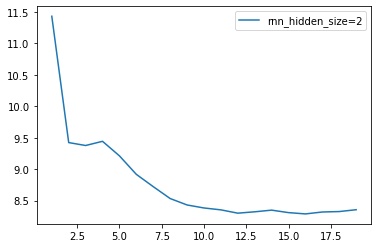

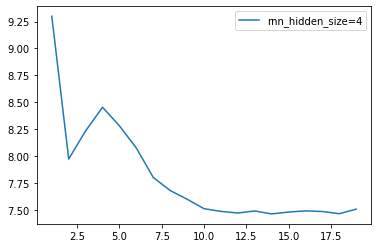

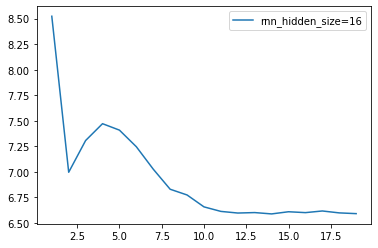

In [42]:
import matplotlib.pyplot as plt

plt.plot(x,y2,label='rnn_hidden_size=2')
plt.legend(frameon=True)
plt.show()
plt.plot(x,y4,label='rnn_hidden_size=4')
plt.legend(frameon=True)
plt.show()
plt.plot(x,y16,label='rnn_hidden_size=16')
plt.legend(frameon=True)
plt.show()
